In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Rough-Draft: 

**Motivating thoughts**: There's a new COVID variant that has been ramping up in South Africa since early August. It's virulent enough and has enough significant mutations present in its spike proteins as to cause the UK to shut down flights incoming from South Africa for the last week or so$^{[1]}$, and the US appears to be following suit$^{[2]}$. Our greatest tool against the spread of COVID has been the development of vaccines that can target the spike protein on a coronavirus. Most of the sufficiently informed population is aware of viral mutations, and we know that if a virus mutates sufficiently, our best vaccines have little hope of being effective. But what are the biggest contributing factors when it comes to providing the opportunity for viral mutation? This question could be asked a thousand different ways. But for today's purposes, I'll ask it in two different ways: 

 - **In countries with low vaccination rates, should we expect to see a higher occurrence of COVID-19 variants? In other words, is there a linear relationship between vaccination rates and COVID-19 variants?** I suspect so.
 - **Are the numbers of variants present in a population independent of population density?** In other words, does population density have some kind of an effect on the number of variants that we might see in a population? 


This data is a composite collection pulled from three different sources:
 - `vaccinations`: This dataset contains information as to the number of vaccinations per country for dates between 2019 and 2021. I will be extracting vaccination data for the month of September from this dataset in order to determine the potential linear relationship between vaccination rates and variants. The full dataset is updated every six hours or so here: https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv
 - `variants` : This data set contains the number of COVID variants present in each country. The dataset that I am using comes from this github page: https://github.com/owid/covid-19-data/blob/master/public/data/variants/covid-variants.csv. The data used to populate this GitHub page comes from CoVariant (see resources).$^{[5]}$. I'll be using this dataset in it's while working through the tests of independence for my second question.</span> 
 - `world_population_by_country` : a simple dataset for estimated populations for every country in the world. Available here: https://worldpopulationreview.com/ 


<br>


## Test 1:

**In countries with low vaccination rates, should we expect to see a higher occurrence of COVID-19 variants? In other words, is there an inverse relationship between vaccination rates and COVID-19 variants?** I suspect so.

To try and answer this question, I'll perform a simple linear regression, evaluate the slope and run Student's t-test on $r$, the correlation coefficient, as well as generating a 99% confidence interval for the test statistic.

There are a few different ways to calculate vaccination rates, so it's important to note that I'll be calculating vaccination rates as (*the number of people in a country who have received at least one dose of any given vaccine*) $\div$ (*the total population for the given country in 2021*). I will also only be looking at September of 2021.

    
$H_0$: There is no relationship between vaccination rates and the numbers of COVID-19 variants for the month of September, thus $r = 0$

$H_a$: There is some relationship between vaccination rates and the numbers of COVID-19 variants for the month of September, thus $r \neq 0$


  
A simple linear model with a slope and an intercept term will be of the form: $\vec{y} = \theta_{0} + \theta_{1}x_{i}$. Where $\vec{y}$ and $\theta$ are some unknown, ideal parameters. Since I like linear algebra, I'll be considering $\hat{y}$ and $x_i$ to be vectors, and using matrix equations to solve for my optimal values of $\theta$. 

I'll want to find some equation of the form $\mathbb{X}\theta = \vec{y}$, but also know that attempting to solve this equation will likely end up with no solution, since there probably is no "perfect" parameter of $\theta$ that can give me $\vec{y}$. Thankfully, I also know that if $\mathbb{X}$ is an $m \times n$ matrix and $\vec{y} \in \mathbb{R}^{m}$, then a least-squares solution of $\mathbb{X} \vec{\theta} = \vec{y}$  is a $\hat{\theta} \in \mathbb{R}^n$ s.t. $\parallel \vec{y} - \mathbb{X}\hat{\theta} \parallel \leq \parallel \vec{y} - \mathbb{X}\vec{\theta}\parallel$. This tells us that if I can find some $\hat{y}$, s.t. $\hat{y} = \mathbb{X}\hat{\theta} = proj_{Col(\mathbb{X})}\vec{y}$, where $\hat{y} \in Col(A)$, and $\mathbb{X}$ is our design matrix, then I can find a least-squares solution to the equation $\mathbb{X}\theta = \vec{y}$.

By the properties of orthogonal projections, we know that $\hat{y}$ is a vector s.t. $\vec{y} - \hat{y}$ is orthogonal to the Col(A), so $\mathbb{X}^T(\vec{y} - \hat{y}) = 0$ (because the dot product of any two vectors that are orthogonal to each other will always be zero). 

And if $\mathbb{X}^T(\vec{y} - \hat{y}) = 0$, then since $\hat{y} = \mathbb{X}\hat{\theta}$, 

$\mathbb{X}^T(\vec{y} - \mathbb{X}\hat{\theta}) = 0$, 

$\mathbb{X}^T\vec{y} - \mathbb{X}^T\mathbb{X}\hat{\theta} = 0$, thus 

$\mathbb{X}^T\mathbb{X}\hat{\theta} = \mathbb{X}^T\vec{y}$ and from here, we can use back-substitution to solve for the optimal vector entries of theta for my simple linear model $\vec{y} = \theta_{0} + \theta_{1}x_{i}$. 

I can also check my work by confirming that $\theta_0 = \overline{y} + \theta_1\overline{x}$ and that $\theta_1 = r\frac{S_{y}}{S_{x}}$, which we can derive with a little bit of calculus, optimizing the mean square error of the residuals. The basic calculus to do this can be summarized as follows: 

$MSE(y,  \hat{y}) = \frac{1}{n}\sum_{i=1}^n (y_{i} - \hat{y}_i)^{2}$, then this becomes $\frac{1}{n}\sum_{i=1}^n (y_{i} - (\theta_0 + \theta_{1}x_{i}))^{2}$

First--remember: 
 - the formula for the covariance, $COV = r\theta_{x}\theta_{y} = \frac{1}{n}\sum_{i=1}^{n}(x_{i} - \overline{x})(y_{i} -\overline{y})$
 - the formula for the variance of the x-values is $VAR = \theta_{x}^2 = \frac{1}{n}\sum(x_{i} - \overline{x})^2$

Start by taking the deriviate of $R$ with respect to $\theta_0$, setting to zero, then solving for $\theta_0$: 

$\frac{\partial{R}}{\partial{\theta_0}} (\frac{1}{n}\sum_{i=1}^n (y_{i} - (\theta_0 + \theta_{1}x_{i}))^{2}) =  -2 (\frac{1}{n} \sum_{i=1}^n (y_{i} - \theta_0 - \theta_{1}x_{i}))$

$ 0 = \frac{-2}{n} \sum_{i=1}^{n} (y_{i} - \theta_0 - \theta_{1}x_{i})$

$ 0 = \sum_{i=1}^{n}y_{i} - \sum_{i=1}^{n}\theta_0 - \theta_{1} \sum_{i=1}^{n}x_{i}$       

$ 0 = - n\theta_0 + \sum_{i=1}^{n}y_{i} - \theta_{1} \sum_{i=1}^{n}x_{i}$ 

$na = \sum_{i=1}^{n}y_{i} - \theta_{1} \sum_{i=1}^{n}x_{i}$ 

$a = \frac{1}{n}\sum_{i=1}^{n}y_{i} - \frac{1}{n} \theta_{1}\sum_{i=1}^{n}x_{i}$ 

$ \therefore \hat{\theta_0} = \overline{y} - \theta_{1} \overline{x}$

Next, take the derivative of $R$ with respect to $\theta_{1}$, setting to zero, then solving for $\theta_{1}$: 

$\frac{\partial{R}}{\partial{\theta_{1}}} (\frac{1}{n}\sum_{i=1}^n (y_{i} - ((\overline{y} - \theta_{1}\overline{x}) + \theta_{1}x_{i}))^{2}) = \frac{\partial{R}}{\partial{\theta_{1}}} (\frac{1}{n}\sum_{i=1}^n (y_{i} - \overline{y} - \theta_{1}\overline{x} - \theta_{1}x_{i})^{2})  = \frac{\partial{R}}{\partial{\theta_{1}}} (\frac{1}{n}\sum_{i=1}^n (y_{i} - \overline{y} - \theta_{1}(x_{i} - \overline{x}))^{2}  = \frac{-2}{n} \sum_{i=1}^{n}(y_{i} - \overline{y} - \theta_{1}(x_{i} - \overline{x}))(x_{i} - \overline{x}) = \frac{-2}{n} \sum_{i=1}^{n}(y_{i} - \overline{y})(x_{i} - \overline{x}) - (\theta_{1}(x_{i} - \overline{x}))(x_{i} - \overline{x})$

$0 = \sum_{i = 1}^{n}(y_{i} - \overline{y})(x_{i} - \overline{x}) - \theta_{1}\sum_{i=1}^{n} (x_{i} - \overline{x})^2$

$0 = n(r\theta_{x}\theta_{y}) - \theta_{1}n(\theta_{x}^2)$

$\theta_{1}n(\theta_{x}^2) = n(r\theta_{x}\theta_{y})$

$\therefore \theta_{1} = r\frac{\theta_{y}}{\theta_{x}}$

Under $H_0$, my **test statistic** will be $t = \frac{r\sqrt{n - 1}}{\sqrt{1 - r^2}}$. 

To review, in order to find my optimal parameters, $\theta_0$ and $\theta_1$, 
 - I'll assemble a design matrix $X$, composed of my independent feature, `vaccination_rates` and a `bias` term.  
 - Then I'll use the normal equation, $X^{T}X\theta = X^T\hat{y}$ which can then be solved to give the optimal parameters for $\theta$
 - I'll check my work by minimizing the mean square of the residuals. 
 - I'll perform a Student's t-test along with a 95% confidence interval to determine whether or not there is a linear relationship between vaccination rates and the number of COVID variants found in countries during the month of September.

<br><br>
_______

## Test 2:

**Are the numbers of variants present in a population independent of population density?** In other words, does population density have some kind of an effect on the number of variants that we might see in a population? 
    
Note: I can imagine that there are myriad other factors that could also contribute to vulnerable populations and higher incidences of COVID variants showing up (for example, poverty, or higher incidences of populations with compromised immune systems), none of which would occur in isolation from each other. But to keep things clear and simple, I wonder if simply the combination of these two factors mentioned above combine to provide higher incidences of COVID variants.
    
To answer this question, I'll use a $\chi^2$ test of independence. I will "discrete-ize" population density as "very high", "high", "medium", and "low".  
    
$H_0$: The number of variants present in any given country is independent of population density.

$H_a$: The number of variants present in any given country is dependent upon population density.

The math for this test is a little easier. Organizing the dataframes will probably be a bit of a bear, but I'll cross that bridge when I get there. 

Essentially, I will compute the expected values, under then null of the probability of the number of variants occurring *and* the population densities (binned into "very high", "high", "medium" and "low" rates). 


**Test statistic** = $\sum_{i \times j} (\frac{(Observed - Expected)^2}{Expected})$
 - $i$ = number of rows in the table
 - $j$ = number of columns in the table

**Determining the degrees of freedom:**
 - $df = i \times j = (i columns - 1)  \times (j columns - 1) = (i - 1) \times (j - 1)$
 
 
NOTE: The expected value for each cell has to be at least 5 in order to use the test for independence. 

<br><br>
_______

## Resources: 
 - $[1]$ https://nypost.com/2021/11/26/new-covid-variant-detected-in-south-africa-prompts-uk-travel-ban/
 - $[2]$ https://www.upi.com/Top_News/US/2021/11/27/state-department-advises-against-travel-south-africa-omicron/3621638049970/
 - $[3]$ https://www.businessinsider.com/map-most-and-least-vaccinated-counties-in-us-2021-5?op=1
 - $[4]$ https://www.usnews.com/news/best-states/articles/these-states-have-the-best-covid-19-vaccination-rates
 - $[5]$ Emma B. Hodcroft. 2021. "CoVariants: SARS-CoV-2 Mutations and Variants of Interest." https://covariants.org/

## Loading Up and Organizing the data

I'll be pulling from the same datasets for each of the two tests. These data come from a couple of different sources, and as such, need a little processing to get them ready for my purposes. 

In [280]:
# Loading the datasets

# Change the path to match your directories
path = "./"

In [281]:
# Starting with the variants data
variants = pd.read_csv(path + "covid-variants.csv").sort_values('location')
variants

# According to the logs for the `variants` dataset, we should be sure to exclude the 'non_who' variant category in order to 
# avoid double-counting. Filtering those out now.
variants_semi_cleaned = variants.loc[variants['variant'] != 'non_who']
len(variants_semi_cleaned) != len(variants)

# Next, although it is interesting to see the different names and labels given to each variant, I don't need that data. 
# I need to know how many variants are present in a given country at a given time. 
pd.set_option('display.max_colwidth', None)
variants_cleaned = variants_semi_cleaned.sort_values('variant').loc[variants_semi_cleaned['perc_sequences'] != 0].groupby(['location', 'date'], as_index=False).agg({'variant': 'size'})
variants_cleaned.rename(columns={'variant': 'variants'}, inplace=True)
variants_cleaned

,location,date,variants
0,Angola,2020-12-21,3
1,Angola,2021-01-25,6
2,Angola,2021-02-08,4
3,Angola,2021-02-22,5
4,Angola,2021-03-08,4
...,...,...,...
2249,Zimbabwe,2021-01-11,2
2250,Zimbabwe,2021-01-25,2
2251,Zimbabwe,2021-02-08,1
2252,Zimbabwe,2021-07-12,1


In [282]:
# Working on the vaccinations data next
vaccinations = pd.read_csv(path + "vaccinations.csv")
vaccinations['year'] = vaccinations['date'].str[0:4]
vaccinations['month'] = vaccinations['date'].str[5:7]
vaccinations

# Getting rid of continental data 
vaccinations = vaccinations.loc[~vaccinations['location'].isin(['Africa', 'Europe', 'World', 'North America', 'South America', 'Asia', 'Upper middle income'])]

# I only care about the month of September
september_vaccinations = vaccinations.loc[vaccinations['month'] == '09']
september_vaccinations

# Selecting only the columns that will be most useful and dropping any individual observations with NaNs
september_vax = september_vaccinations[['location', 'date', 'year', 'month', 'people_vaccinated']].dropna().sort_values(['location', 'date'])
september_vax

,location,date,year,month,people_vaccinated
220,Afghanistan,2021-09-30,2021,09,828601.0
828,Albania,2021-09-01,2021,09,836613.0
829,Albania,2021-09-02,2021,09,844304.0
833,Albania,2021-09-06,2021,09,865281.0
834,Albania,2021-09-07,2021,09,872116.0
...,...,...,...,...,...
64187,Zimbabwe,2021-09-26,2021,09,3027050.0
64188,Zimbabwe,2021-09-27,2021,09,3041408.0
64189,Zimbabwe,2021-09-28,2021,09,3050513.0
64190,Zimbabwe,2021-09-29,2021,09,3062070.0


In [283]:
# Getting the populations for each country next

world_population_by_country = pd.read_csv(path + 'world_population_2019.csv').sort_values('name')

# These data for populations are in millions. Converting them now just for clarity
for column in world_population_by_country.columns: 
    if 'pop20' in column: 
        world_population_by_country[column] = world_population_by_country[column] * 1_000

# Not sure what values the 'Density' column are based off of, so creating my own column to work off of for the year I'm interested in
world_population_by_country['density2021'] = world_population_by_country['area'] / world_population_by_country['pop2021']
world_population_by_country

# Once again, I only care about September 2021, and population density for that year
# so I'm going to get rid of the other columns via the creation of a new dataframe
population_params = world_population_by_country[['name', 'pop2021', 'area', 'density2021']]
population_params

,name,pop2021,area,density2021
36,Afghanistan,39835428.0,652230,0.016373
139,Albania,2872933.0,28748,0.010006
33,Algeria,44616624.0,2381741,0.053382
208,American Samoa,55100.0,199,0.003612
201,Andorra,77355.0,468,0.006050
...,...,...,...,...
223,Wallis and Futuna,11094.0,142,0.012800
169,Western Sahara,611875.0,266000,0.434729
47,Yemen,30490640.0,527968,0.017316
64,Zambia,18920651.0,752612,0.039777


After cleaning and simplifying my data, I'm left with three "meta" dataframes that I'll be merging together to create my final working dataframe. 
 - `variants_cleaned` is a new dataframe, composed of the total numbers of variants present in a given country on a given date.
 - `september_vax` which is composed of the daily vaccine counts for the month of September for all countries. 
 - `population_params`, which is composed of some useful population information, per country. 
 
Finally, I think it's time to merge them all together to get one big, useful dataframe. 

In [236]:
display(variants_cleaned.head(2), september_vax.head(2), population_params.head(2))

,location,date,variants
0,Angola,2020-12-21,3
1,Angola,2021-01-25,6


,location,date,year,month,people_vaccinated
220,Afghanistan,2021-09-30,2021,09,828601.0
828,Albania,2021-09-01,2021,09,836613.0


,name,pop2021,area,density2021
36,Afghanistan,39835428.0,652230,0.016373
139,Albania,2872933.0,28748,0.010006


In [237]:
# Performing the first merge
september_variants_and_vaccinations = (pd.merge(variants_cleaned, september_vax, how='left', left_on=['location', 'date'], right_on=['location', 'date'])
                             .sort_values(['location', 'date']).dropna())
september_variants_and_vaccinations

,location,date,variants,year,month,people_vaccinated
47,Argentina,2021-09-06,6,2021,09,28344998.0
48,Argentina,2021-09-20,3,2021,09,29032591.0
63,Aruba,2021-09-06,2,2021,09,79209.0
64,Aruba,2021-09-20,1,2021,09,80707.0
102,Australia,2021-09-06,3,2021,09,13160225.0
...,...,...,...,...,...,...
2173,United Kingdom,2021-09-20,2,2021,09,48604764.0
2214,United States,2021-09-06,6,2021,09,208430319.0
2215,United States,2021-09-20,7,2021,09,212586241.0
2232,Vietnam,2021-09-06,1,2021,09,19231238.0


In [255]:
# Allllmost done
sep_variants_vaccines_populations = pd.merge(september_variants_and_vaccinations, population_params, how='left', left_on=['location'], right_on=['name']).filter(['location', 'date', 'variants', 'people_vaccinated', 'pop2021', 'density2021'])
sep_variants_vaccines_populations["vaccination_rate"] = sep_variants_vaccines_populations['people_vaccinated'] / sep_variants_vaccines_populations['pop2021']
sep_variants_vaccines_populations

,location,variants,density2021,vaccination_rate
0,Argentina,4.5,0.060966,0.629060
1,Aruba,1.5,0.001679,0.745849
2,Australia,2.0,0.298277,0.550100
3,Austria,2.0,0.009275,0.621353
4,Bahrain,1.0,0.000438,0.658950
...,...,...,...,...
62,Turkey,1.5,0.009214,0.604235
63,Ukraine,1.0,0.013884,0.146478
64,United Kingdom,2.5,0.003561,0.710319
65,United States,6.5,0.028153,0.632318


In [285]:
# Finally, this is my finished dataframe that I'll be working with. 
# This final dataframe is the average number of variants and average vaccination rates for every country, for the month of September.
september = sep_variants_vaccines_populations.groupby(['location'], as_index=False).agg({'variants': np.mean, 'density2021': np.mean, 'vaccination_rate': np.mean})
september

,location,variants,density2021,vaccination_rate
0,Argentina,4.5,0.060966,0.629060
1,Aruba,1.5,0.001679,0.745849
2,Australia,2.0,0.298277,0.550100
3,Austria,2.0,0.009275,0.621353
4,Bahrain,1.0,0.000438,0.658950
...,...,...,...,...
62,Turkey,1.5,0.009214,0.604235
63,Ukraine,1.0,0.013884,0.146478
64,United Kingdom,2.5,0.003561,0.710319
65,United States,6.5,0.028153,0.632318


Finally, I've gotten all of the data I care about into one, easy to read dataframe, `september`.

# In countries with low vaccination rates, should we expect to see a higher occurrence of COVID-19 variants?

### Performing some initial exploratory data analysis

In [261]:
# Getting the 5-number summary for the vaccination rates for all countries
september["vaccination_rate"].describe()

count    65.000000
mean      0.535961
std       0.215324
min       0.013060
25%       0.404601
50%       0.604372
75%       0.695352
max       0.869343
Name: vaccination_rate, dtype: float64

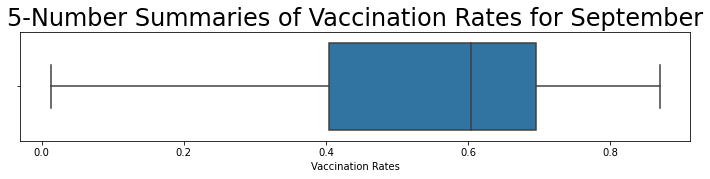

In [278]:
plt.figure(figsize=(12, 2))
sns.boxplot(x='vaccination_rate', data=september);
plt.xlabel("Vaccination Rates")
plt.title("5-Number Summaries of Vaccination Rates for September", fontsize=24);

<br><br>

In [264]:
# Getting the 5-number summary for the number of variants in all of the countries
september['variants'].describe()

count    67.000000
mean      2.485075
std       1.602484
min       1.000000
25%       1.000000
50%       2.000000
75%       3.250000
max       7.000000
Name: variants, dtype: float64

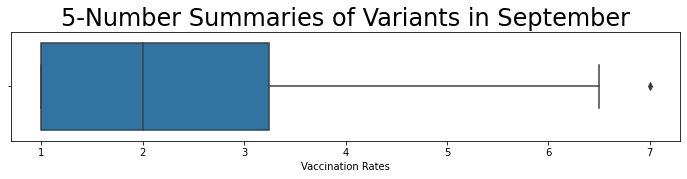

In [277]:
plt.figure(figsize=(12, 2))
sns.boxplot(x='variants', data=september);
plt.xlabel("Vaccination Rates")
plt.title("5-Number Summaries of Variants in September", fontsize=24);

<br><br>

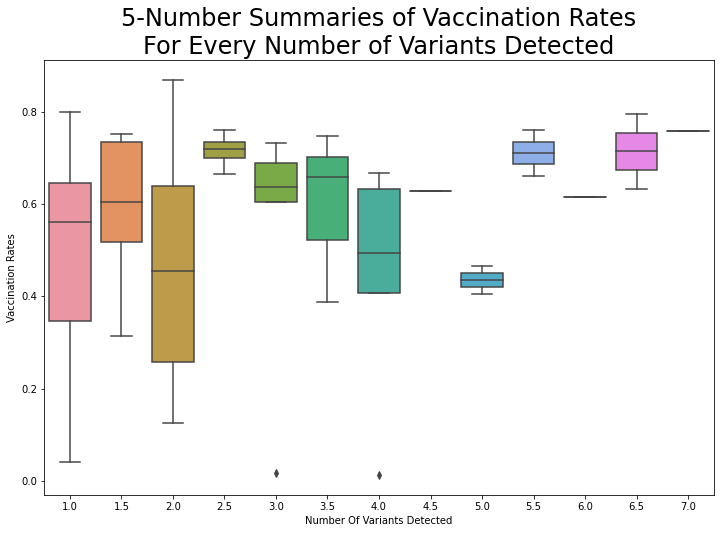

In [273]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='variants', y='vaccination_rate', data=september);
plt.xlabel("Number Of Variants Detected")
plt.ylabel("Vaccination Rates")
plt.title("5-Number Summaries of Vaccination RatesFor Every Number of Variants Detected", fontsize=24);

<span style="color:blue">Doing some initial visualization to see if regression would be a good fit for this data.</span>

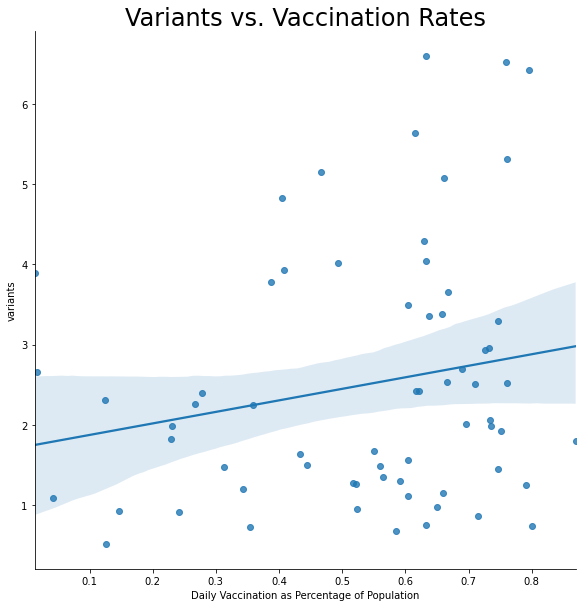

In [279]:
sns.lmplot(x='vaccination_rate', y='variants', data=september, fit_reg=True, y_jitter=.5, height=8)
plt.title("Variants vs. Vaccination Rates", fontsize=24);
plt.xlabel("Daily Vaccination as Percentage of Population");

<br><br>

<br><br>

Based on this initial exploratory data analysis, I think there could be a possible linear relationship between the number of variants and any given country's vaccination rates. It will be interesting to see how strong that correlation might be.

<br><br>

<br><br><br>
___________

# Are the numbers of variants present in a population independent of population density?

In other words, does population density have some kind of an effect on the number of variants that we might see in a population? 

### Initial Exploratory Data Analysis

In [288]:
display(variants_cleaned.sample(2), population_params.sample(2))

,location,date,variants
525,Denmark,2020-11-09,7
397,Chile,2021-07-26,6


,name,pop2021,area,density2021
2,United States,332915073.0,9372610,0.028153
90,Sweden,10160169.0,450295,0.044320


In [291]:
# Creating one new master dataframe from which to pull all of my variant and density data
variant_density = pd.merge(variants_cleaned, population_params, how='left', left_on='location', right_on='name').filter(['location', 'date', 'variants', 'density2021'])
variant_density

,location,date,variants,density2021
0,Angola,2020-12-21,3,0.036739
1,Angola,2021-01-25,6,0.036739
2,Angola,2021-02-08,4,0.036739
3,Angola,2021-02-22,5,0.036739
4,Angola,2021-03-08,4,0.036739
...,...,...,...,...
2249,Zimbabwe,2021-01-11,2,0.025891
2250,Zimbabwe,2021-01-25,2,0.025891
2251,Zimbabwe,2021-02-08,1,0.025891
2252,Zimbabwe,2021-07-12,1,0.025891


In [292]:
variant_density['variants'].describe()

count    2254.000000
mean        4.288376
std         3.164702
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: variants, dtype: float64

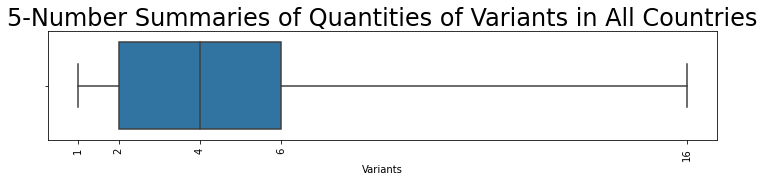

In [324]:
plt.figure(figsize=(12, 2))
sns.boxplot(x='variants', whis=[0, 100], data=variant_density);
plt.xlabel("Variants")
plt.title("5-Number Summaries of Quantities of Variants in All Countries", fontsize=24);
plt.xticks(variant_density['variants'].describe()[3:9], rotation=90);

In [313]:
variant_density['density2021'].describe()

count    2206.000000
mean        0.034042
std         0.067090
min         0.000120
25%         0.004084
50%         0.009753
75%         0.028153
max         0.299983
Name: density2021, dtype: float64

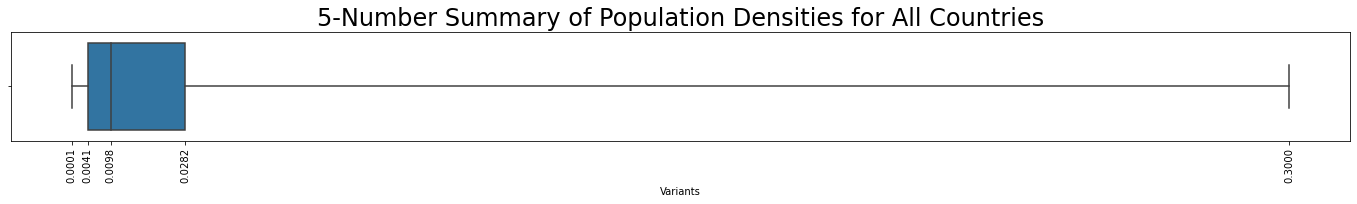

In [325]:
plt.figure(figsize=(24, 2))
sns.boxplot(x='density2021', whis=[0, 100], data=variant_density);
plt.xlabel("Variants")
plt.title("5-Number Summary of Population Densities for All Countries", fontsize=24);
plt.xticks(variant_density['density2021'].describe()[3:9], rotation=90);

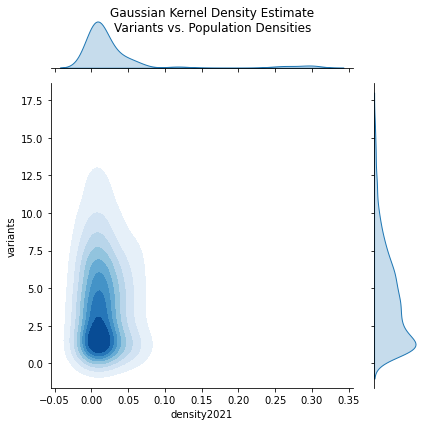

In [311]:
p = sns.jointplot(x='density2021', y='variants', data=variant_density, kind='kde', fill=True, cmap='Blues');
p.fig.suptitle("Gaussian Kernel Density Estimate\nVariants vs. Population Densities")
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
